In [74]:
import numpy as np
import librosa
from scipy.signal import get_window
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 5)

In [2]:
def my_windowing(
    v_signal: np.ndarray,
    sampling_rate: int,
    frame_length: int,
    frame_shift: int = None,
) -> list[np.ndarray]:
    if frame_shift is None:
        frame_shift = frame_length

    frame_len_samples = np.floor(frame_length * sampling_rate / 1000).astype(int)
    frame_shift_samples = np.floor(frame_shift * sampling_rate / 1000).astype(int)
    m_frames = []
    frame_centers = []
    for i in range(0, len(v_signal) - frame_len_samples, frame_shift_samples):
        m_frames.append(v_signal[i : i + frame_len_samples])
        frame_centers.append((i + frame_len_samples // 2) * 1000 / sampling_rate)
    return np.array(m_frames), np.array(frame_centers)

n_frames = (signal_length - frame_length) / frame_shift + 1

## 1. Short-time Fourier Transform

In [68]:
def compute_stft(
    v_signal: np.ndarray,
    fs: int,
    frame_length: int,
    frame_shift: int,
    v_analysis_window: np.ndarray,
) -> list[np.ndarray]:
    """Compute the short-time Fourier transform of a signal."""
    frames, frame_centers = my_windowing(v_signal, fs, frame_length, frame_shift)
    frames *= v_analysis_window
    spectrum = np.fft.fft(frames, axis=1)
    # remove upper half of the spectrum
    spectrum = spectrum[:, : spectrum.shape[1] // 2 + 1]

    # check with np.fft.rfft
    spectrum2 = np.fft.rfft(frames, axis=1)
    print("Output matches np.fft.rfft:", np.allclose(spectrum, spectrum2))

    return spectrum, frame_centers

In [112]:
s1, sampling_rate = librosa.core.load("Audio/speech1.wav", sr=None)
print(len(s1) / sampling_rate, "s")

s2, sampling_rate = librosa.core.load("Audio/phone.wav", sr=None)
print(len(s2) / sampling_rate, "s")

2.841625 s
2.0 s


In [113]:
m_stft, frame_centers = compute_stft(s1, sampling_rate, 25, 10, np.hamming(25 * sampling_rate // 1000))

Output matches np.fft.rfft: True


## 2. Spectral analysis

### a) Log magnitude spectrogram

In [153]:
def plot_log_spectrogram(
    signal: np.ndarray,
    sampling_rate: int,
    frame_length: int = 32,
    frame_shift: int = 8,
    threshold: float = None,
) -> None:
    """Plot the log spectrogram of a signal."""
    m_stft, v_time = compute_stft(
        signal,
        sampling_rate,
        frame_length,
        frame_shift,
        get_window("hann", frame_length * sampling_rate // 1000),
    )

    magnitude = 10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15)))

    v_freq = np.linspace(0, sampling_rate / 2, m_stft.shape[1])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(
        magnitude,
        cmap="viridis",
        origin="lower",
        extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
        aspect="auto",
    )

    if threshold is not None:
        # plot parts of the spectrogram that are above the threshold
        ax.contour(
            v_time,
            v_freq,
            magnitude,
            levels=[threshold],
            colors="red",
            linestyles="solid",
            linewidths=1,
        )

    fig.colorbar(im, orientation="vertical", pad=0.01)
    im.colorbar.set_label("Magnitude [dB]", rotation=270, labelpad=15)

    ax.set_title(f"Log spectrogram \n (frame length: {frame_length} ms, frame shift: {frame_shift} ms)")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Frequency [Hz]")

    fig.tight_layout()
    plt.show()


Output matches np.fft.rfft: True


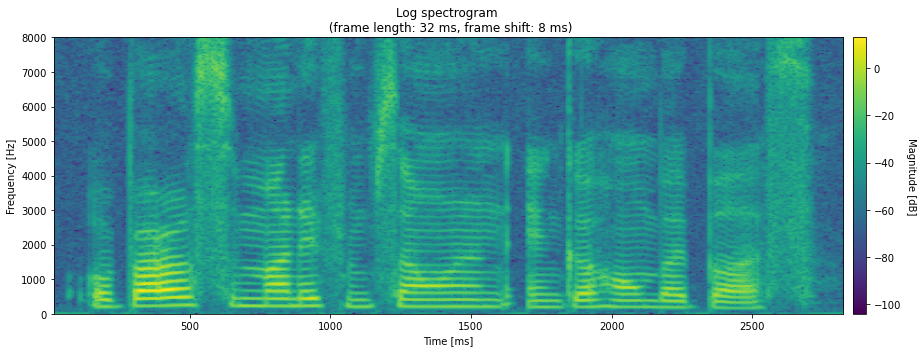

In [154]:
plot_log_spectrogram(s1, sampling_rate, frame_length=32, frame_shift=8)

Output matches np.fft.rfft: True


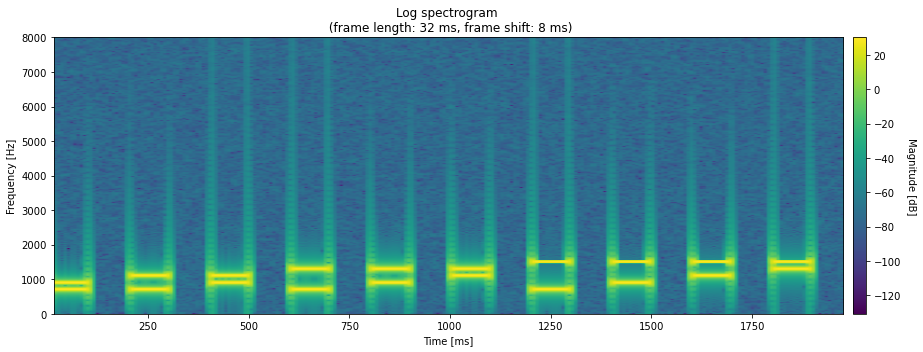

In [155]:
plot_log_spectrogram(s2, sampling_rate, frame_length=32, frame_shift=8)

### c) Frame length = 8 ms, frame shift = 2 ms

Output matches np.fft.rfft: True


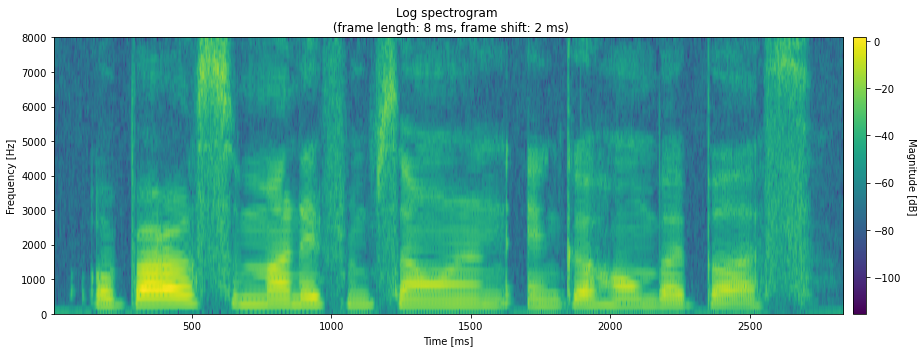

In [156]:
plot_log_spectrogram(s1, sampling_rate, frame_length=8, frame_shift=2)

Output matches np.fft.rfft: True


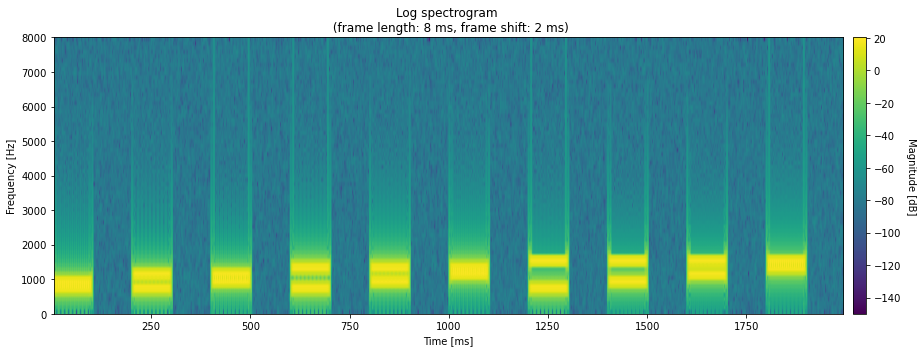

In [157]:
plot_log_spectrogram(s2, sampling_rate, frame_length=8, frame_shift=2)

### d) Frame length = 128 ms, frame shift = 32 ms

Output matches np.fft.rfft: True


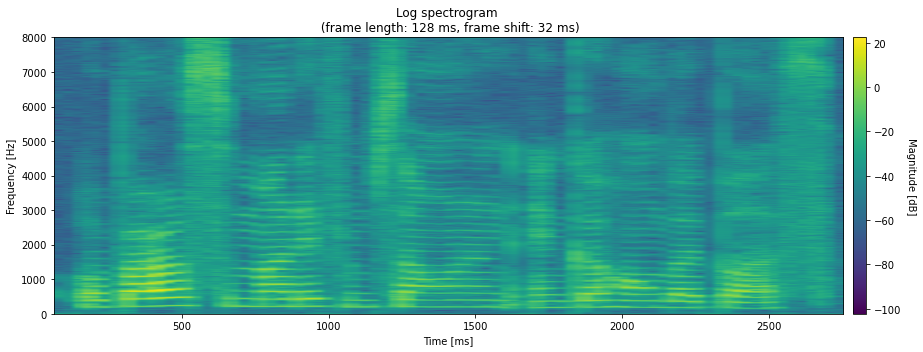

In [158]:
plot_log_spectrogram(s1, sampling_rate, frame_length=128, frame_shift=32)

Output matches np.fft.rfft: True


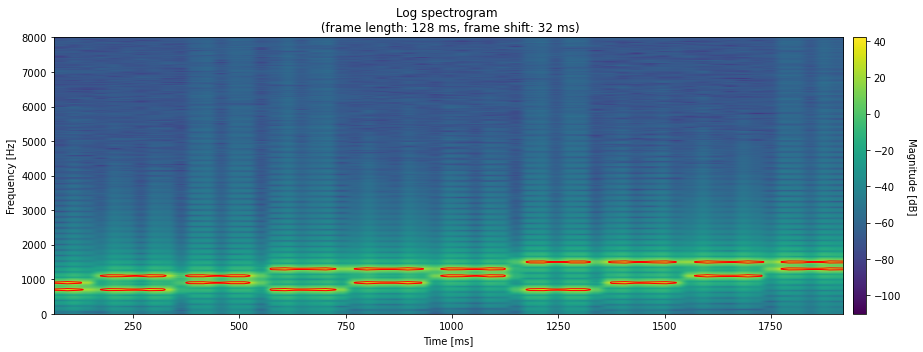

In [161]:
plot_log_spectrogram(s2, sampling_rate, frame_length=128, frame_shift=32, threshold=20.)